In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [71.1 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:14 http://ppa.launchpad.net/gr

In [ ]:
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=76036277844fabfd3e340fdc62515232b0da8ba29a5455d5fa466dd50f41ba0f
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.3.1-bin-hadoop3'

In [ ]:
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.functions import isnull, when, count, col, isnan
from pyspark import SparkFiles
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

spark = SparkSession.builder \
        .master('local') \
        .appName("NY Parking Violation") \
        .config("spark.sql.adaptive.enabled","true") \
        .config("spark.executor.memory","10g") \
        .config("spark.driver.memory","10g") \
        .getOrCreate()
spark

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving PV.00002.csv to PV.00002.csv


In [ ]:
## ensure to use the link of the raw file of the csv
# url = "https://data.cityofnewyork.us/api/views/pvqr-7yc4/rows.csv"

In [ ]:
# spark.sparkContext.addFile(url)

In [ ]:
# df = spark.read.csv(SparkFiles.get("rows.csv"),inferSchema=True, header= True)

In [ ]:
df = spark.read.csv("/content/PV.00001.csv",inferSchema=True, header=True)

In [ ]:
df.count(),len(df.columns)

(100000, 51)

In [ ]:
df.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Plate Type: string (nullable = true)
 |-- Issue Date: string (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Issuing Agency: string (nullable = true)
 |-- Street Code1: integer (nullable = true)
 |-- Street Code2: integer (nullable = true)
 |-- Street Code3: integer (nullable = true)
 |-- Vehicle Expiration Date: integer (nullable = true)
 |-- Violation Location: integer (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Issuer Code: integer (nullable = true)
 |-- Issuer Command: string (nullable = true)
 |-- Issuer Squad: string (nullable = true)
 |-- Violation Time: string (nullable = true)
 |-- Time First Observed: string (nullable = true)
 |-- Violation Coun

## Analyze and preprocess the data

In [ ]:
# Remove all columns which have more than 70% null values

null_threshold = 0.70
columns_valid = [x for x in df.columns if df.filter(F.col(x).isNull()).count()/df.count() < null_threshold]
df = df.select(*columns_valid)
df.count(), len(df.columns)

(100000, 37)

In [ ]:
df.printSchema()

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Plate Type: string (nullable = true)
 |-- Issue Date: string (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Issuing Agency: string (nullable = true)
 |-- Street Code1: integer (nullable = true)
 |-- Street Code2: integer (nullable = true)
 |-- Street Code3: integer (nullable = true)
 |-- Vehicle Expiration Date: integer (nullable = true)
 |-- Violation Location: integer (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Issuer Code: integer (nullable = true)
 |-- Issuer Command: string (nullable = true)
 |-- Issuer Squad: string (nullable = true)
 |-- Violation Time: string (nullable = true)
 |-- Violation County: string (nullable = true)
 |-- Violation In Fron

In [ ]:
columns_selected = ["Registration State","Plate Type",\
                "Violation Code", "Vehicle Body Type","Vehicle Make","Issuing Agency", "Street Code1", \
               "Street Code2","Street Code3","Violation Location","Violation Precinct", \
               "Issuer Precinct","Issuer Code","Issuer Command",\
               "Violation County","Law Section","Sub Division","Vehicle Color"]

In [ ]:
# removed the Violation_Legal_Code, summons_number , plate_id as it has same values
df = df.select(columns_selected)

In [ ]:
# clean up the data as many have incorrect values.
df = df[(df['Registration State'] != "99") & (df['Plate Type'] != "999") \
        & (df['Violation Code'] != 0)]

In [ ]:
# Check if the null value still exist
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------------------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+------------------+------------------+---------------+-----------+--------------+----------------+-----------+------------+-------------+
|Registration State|Plate Type|Violation Code|Vehicle Body Type|Vehicle Make|Issuing Agency|Street Code1|Street Code2|Street Code3|Violation Location|Violation Precinct|Issuer Precinct|Issuer Code|Issuer Command|Violation County|Law Section|Sub Division|Vehicle Color|
+------------------+----------+--------------+-----------------+------------+--------------+------------+------------+------------+------------------+------------------+---------------+-----------+--------------+----------------+-----------+------------+-------------+
|                 0|         0|             0|             4928|        3237|             0|           0|           0|           0|             26180|                 0|              0|        

In [ ]:
df.toPandas().nunique()

Registration State       60
Plate Type               46
Violation Code           90
Vehicle Body Type       336
Vehicle Make            731
Issuing Agency           12
Street Code1           3422
Street Code2           3719
Street Code3           3648
Violation Location      135
Violation Precinct      136
Issuer Precinct         277
Issuer Code           10952
Issuer Command          602
Violation County          7
Law Section               2
Sub Division            122
Vehicle Color           489
dtype: int64

In [ ]:
df = df.na.drop()

In [ ]:
df.dropDuplicates()

DataFrame[Registration State: string, Plate Type: string, Violation Code: int, Vehicle Body Type: string, Vehicle Make: string, Issuing Agency: string, Street Code1: int, Street Code2: int, Street Code3: int, Violation Location: int, Violation Precinct: int, Issuer Precinct: int, Issuer Code: int, Issuer Command: string, Violation County: string, Law Section: int, Sub Division: string, Vehicle Color: string]

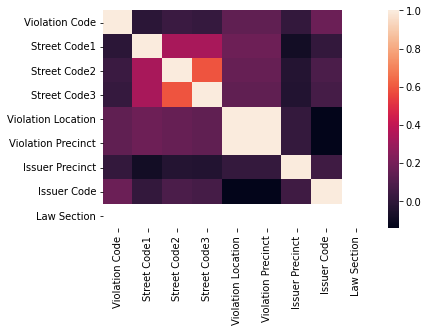

In [ ]:
sns.heatmap(df.toPandas().corr())

In [ ]:
# check how labels are ditributed
df.toPandas()['Violation Location'].value_counts()

19     4227
1      2070
14     1884
18     1883
109    1700
       ... 
678       1
92        1
152       1
138       1
162       1
Name: Violation Location, Length: 127, dtype: int64

In [ ]:
df.createOrReplaceTempView("nyc")

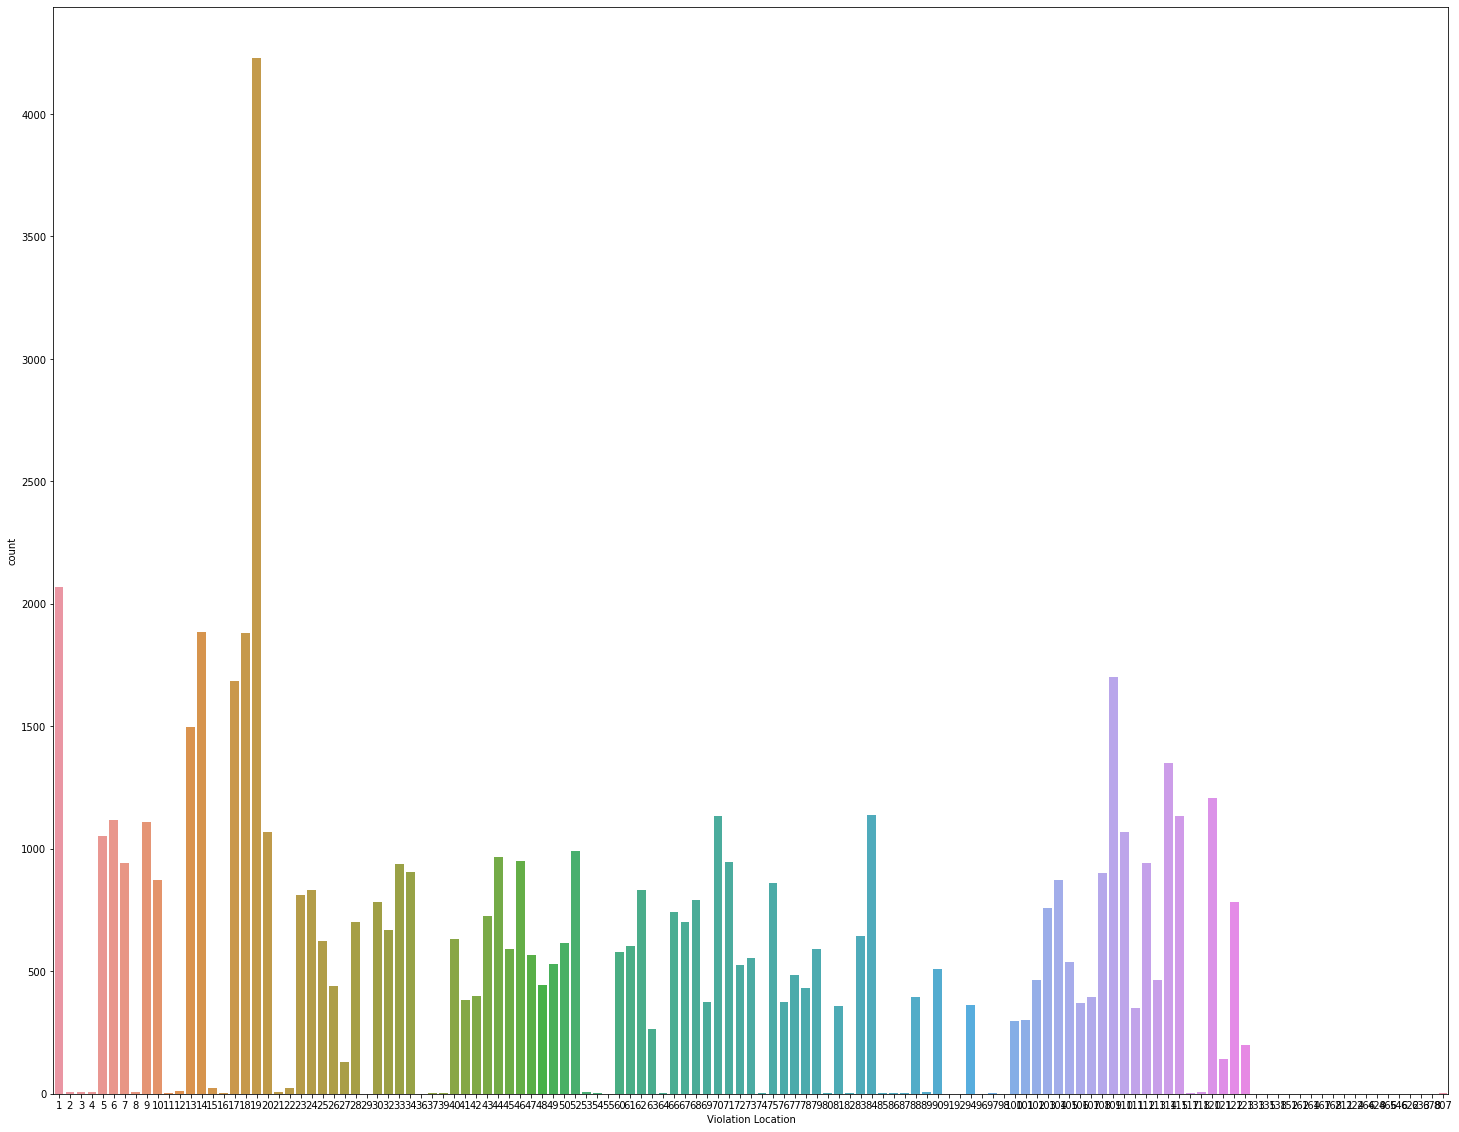

In [ ]:
violation_table = df.groupBy('Violation Location').count()
fig = plt.figure(figsize =(25, 20))
sns.barplot(x='Violation Location',y='count',data=violation_table.toPandas())
plt.show()

In [ ]:
# from pyspark.sql.functions import *
# df=df.withColumn("IssueDate", to_timestamp(col("Issue_Date")))
# type(df)

In [ ]:
from pyspark.sql.types import StringType,DoubleType

cols = [F.col(field[0]).cast('double') if (field[1] == 'int') else F.col(field[0]) for field in df.dtypes]
df = df.select(cols)
df.printSchema()

root
 |-- Registration State: string (nullable = true)
 |-- Plate Type: string (nullable = true)
 |-- Violation Code: double (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Issuing Agency: string (nullable = true)
 |-- Street Code1: double (nullable = true)
 |-- Street Code2: double (nullable = true)
 |-- Street Code3: double (nullable = true)
 |-- Violation Location: double (nullable = true)
 |-- Violation Precinct: double (nullable = true)
 |-- Issuer Precinct: double (nullable = true)
 |-- Issuer Code: double (nullable = true)
 |-- Issuer Command: string (nullable = true)
 |-- Violation County: string (nullable = true)
 |-- Law Section: double (nullable = true)
 |-- Sub Division: string (nullable = true)
 |-- Vehicle Color: string (nullable = true)



In [ ]:
label_count=len(df.select('Violation Location').distinct().collect())
print(label_count)

127


## Convert categorical data to numerical then to vector assemle the data for ML lib

In [ ]:
# Split the data into categorical and continuos to use it pipeline
cat_columns = [x for (x, dataType) in df.dtypes if dataType == 'string']
num_columns = [x for (x, dataType) in df.dtypes if ((dataType != 'string') & (x != 'Violation_Location'))]

In [ ]:
# convert categorical to string indexer then to one hot encoder using pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel

#1. Convert to string indexer
indexers = [ StringIndexer(inputCol=c,  handleInvalid="skip",outputCol="{0}_indexed".format(c)) for c in cat_columns ]


#2. Convert to OnehotEncoder
encoders = [ OneHotEncoder(
                inputCol=indexer.getOutputCol(),
                outputCol="{0}_encoded".format(indexer.getOutputCol()))
             for indexer in indexers ]


#3. Assembler
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + num_columns, outputCol="features_vect")
## MinMax Scalar
scaler = MinMaxScaler(inputCol="features_vect", outputCol="features_scaled")

pipeline = Pipeline(stages=indexers + encoders+ [assembler]+[scaler])

pipeline_model = pipeline.fit(df)
# save the model for fitting the data for prediction
pipeline_model.save("va_model")

df = pipeline_model.transform(df)


***Note that above data transformation pipeline is saved as model to transform the new data for prediction***

In [ ]:
# There are more labels than standard multi label classifier support to predict. So lets index the label.
label_indexer = StringIndexer(inputCol="Violation Location", outputCol="VL_indexed")
label_indexers_model = label_indexer.fit(df)
df= label_indexers_model.transform(df)

In [ ]:
# Display the features column to check whether its dense or sparse vector
df.select("features_scaled","VL_indexed").show(3)

+--------------------+----------+
|     features_scaled|VL_indexed|
+--------------------+----------+
|(1926,[0,60,99,30...|      23.0|
|(1926,[0,60,99,30...|      23.0|
|(1926,[0,60,104,3...|      23.0|
+--------------------+----------+
only showing top 3 rows



In [ ]:
# from pyspark.ml.linalg import Vectors, VectorUDT

# # define function to convert parse to dense vector
# sparseToDense = F.udf(lambda v : Vectors.dense(v), VectorUDT())

# densefeatureDF = df.withColumn('dense_features', sparseToDense('features_scaled'))

# densefeatureDF.select("features_scaled", "dense_features").show(1)

In [ ]:
data = df.select(F.col("features_scaled").alias("features"),
                          F.col("VL_indexed").alias("label"))

In [ ]:
# cache and persist
from pyspark import StorageLevel

# persist the dataframe in both memo
persist_data = data.persist(StorageLevel.MEMORY_AND_DISK)

In [ ]:
trainDF, testDF =  persist_data.randomSplit([0.7,0.3], seed = 2642)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# rf_model = RandomForestClassifier(featuresCol='features', labelCol='label', 
#                     predictionCol='prediction',maxDepth=30, 
#                     impurity='gini', subsamplingRate= .5).fit(trainDF)
# pred = rf_model.transform(testDF)
# pred.show(3)

rf = RandomForestClassifier(featuresCol='features', labelCol='label', 
                    predictionCol='prediction', impurity='gini')

paramGrid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [30]) \
    .addGrid(rf.subsamplingRate, [0.1, 0.5])\
    .addGrid(rf.numTrees, [20,40])\
    .build()

evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")

rf_tvs = TrainValidationSplit(estimator=rf,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)
rf_tvs_model = rf_tvs.fit(trainDF)
rf_predictonDF = rf_tvs_model.transform(testDF)
acc = evaluator.evaluate(rf_predictonDF)
print("Prediction Accuracy: ", acc)
rf_predictonDF.select("features","label", "prediction").show(5)


Prediction Accuracy:  0.8608196539256541
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(1926,[0,59,98,30...|  0.0|       0.0|
|(1926,[0,59,98,30...| 24.0|      24.0|
|(1926,[0,59,98,30...| 34.0|      40.0|
|(1926,[0,59,98,30...| 23.0|      24.0|
|(1926,[0,59,98,30...| 24.0|      23.0|
+--------------------+-----+----------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import IndexToString
from pyspark.sql.types import DoubleType
from pyspark.ml import PipelineModel
import os

dirname = os.getcwd()
print('path=',dirname)
# get the best model and save it
lr_model = rf_tvs_model.bestModel
filename = "rf_model"
model_path= os.path.join(dirname, filename)
print(model_path)
# Index to String converter to get the location
label_conv = IndexToString(inputCol="prediction", outputCol="Violation_Location", labels=label_indexers_model.labels)
# save the Randomforest regression model as pipeline model
pm = PipelineModel(stages=[lr_model,label_conv])
# Write the model
pm.save(filename)

path= /content
/content/rf_model


***Best model from TrainValidationSplit is stored along with converion for prediction to violation location using index to string. *** 

In [ ]:
from google.colab import files
!zip -r 'rf_model.zip' 'rf_model'
!zip -r 'va_model.zip' 'va_model'

files.download('/content/rf_model.zip')
files.download('/content/va_model.zip')

In [ ]:
from sklearn.metrics import confusion_matrix
from pyspark.ml.feature import IndexToString
from pyspark.sql.types import DoubleType

label_conv = IndexToString(inputCol="prediction", outputCol="Violation_Location", labels=label_indexers_model.labels)
pred_label = label_conv.transform(rf_predictonDF)



# convert Violation_Location to DoubleType for accuracy calulation.
pred_label = pred_label.withColumn("Violation_Location", col("Violation_Location").cast(DoubleType()))
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred_label)
print("Prediction Accuracy: ", acc)

In [ ]:
# import PipelineModel from pyspark.ml package
from pyspark.ml import PipelineModel
import os
import zipfile
dirname = os.getcwd()
print('path=',dirname)

rf_filename = "rf_model"
model_path= os.path.join(dirname, rf_filename)

print(model_path)
# load the model from the location it is stored
# The loaded model acts as PipelineModel
pipeline = PipelineModel.load(model_path)

# use the PipelineModel object to perform prediciton on test data. 
# Use .transform() to perfrom prediction
prediction = pipeline.transform(testDF)

# print the results
# prediction.select('label','prediction','Violation_Location').show(5)
prediction.select('prediction','Violation_Location').show(5)

In [ ]:

spark.stop() 

Fit the model and check the accuracy